# Nonlinear analysis -Assignment 2

03.10.2023 - Laure Toullier and Jérémie Engler

## Exercice 1

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Definitions

In [2]:
# Element connectivity
nelements = 2 
nnodes = 3

# Written input:
connectivity = np.array([[1, 2], [3, 2]])
nodes_P = np.array([2])

# Unit stiffness matrix of bar in local coordinate system
K_unit = np.array([[1, 0, -1, 0], 
                   [0, 0,  0, 0], 
                   [-1, 0, 1, 0], 
                   [0, 0, 0, 0]])

# Input data and element stiffness matrices
E = [200e3,200e3]  # N/mm^2 Young modulus of the elements
A = [15e3,2e3] #mm^2 Cross-sectional area of the elements
a = 3000 #mm Half lenght of the truss
b = 4000 #mm Height of the truss
P = 10000e3 #7862e3 #N Load
phiP = 60 #° Angle of load
theta = [53.13, -53.13] #° Angle of elements, at first node of the element
Pglob = np.array([P*np.cos(np.radians(phiP)), P*np.sin(np.radians(phiP))]) #N P force in global coordinates (x,y)
alpha = 0.02
sigmay = 500 #Mpa

#Variables and tracking vectors initialization

plastifiedelem = [] #Track which elements are plastified
Pcp = []
lambdatemp = []
alphaelem = [1,1]
Ucp = np.zeros((nelements,2,1))
Pglobit = Pglob

#Initialisation of the plotted vectors

u = [0]
v = [0]
px = [0]
py = [0]
p = [0]

Functions definitions

In [3]:
def lengths_rotmat_and_Fy():

    #Length of elements, rotation matrices and yielding forces

    T = np.zeros((nelements,4,4))
    L = []
    Fy = []

    for i in range(nelements):
        c = np.cos(np.radians(theta[i]))
        s = np.sin(np.radians(theta[i]))
        Li = abs(a/c)
        if theta[i] == -90:
            Li = b
        T[i] = np.array([[c, s, 0, 0], 
                [-s, c, 0, 0], 
                [0, 0, c, s], 
                [0, 0, -s, c]])
        L.append(Li)
        Fyi = sigmay * A[i]
        Fy.append(Fyi)

    return L,T,Fy

def stiffness_matrices(T,L):

    k = []
    k_glob = np.zeros((nelements,4,4))

    #Stiffness matrices

    for i in range(nelements):
        ki = E[i] * A[i] / L[i]
        k.append(ki)
        k_glob[i] = ki * T[i].T @ K_unit @ T[i]
    
    return k,k_glob

def assemble(alphaelem):
    # Assemble global stiffness matrix
    NDoF = 2*nnodes
    K_global = np.zeros((NDoF,NDoF))
    K_globals = np.zeros((nelements,NDoF, NDoF))
# Assemble elements
    for i in range (nelements):
        connectelem = connectivity[i] #nodes connected to the element
        indexs = 2*connectelem
        i11 = indexs[0]-2
        i12 = indexs[0]
        i21 = indexs[1]-2
        i22 = indexs[1]

        Ki_global = np.zeros((NDoF, NDoF))
        ki_global = alphaelem[i]*k_glob[i]
        Ki_global[i11:i12, i11:i12] = ki_global[0:2, 0:2]
        Ki_global[i21:i22, i11:i12] = ki_global[2:4, 0:2]
        Ki_global[i11:i12, i21:i22] = ki_global[0:2, 2:4]
        Ki_global[i21:i22, i21:i22] = ki_global[2:4, 2:4]
        K_global = K_global + Ki_global
        K_globals[i] = Ki_global

    return(K_global,K_globals)

def u_vec_and_F(P,K_global):
    # Calculate displacements at nodes with forces applied
    numnodesP = len(nodes_P)
    F_red = P
    # print(f"Applied force at iteration {len(plastifiedelem)} = {F_red}")
    indexssup = 2*nodes_P - 1
    indexsinf = indexssup - 1
    mask = []
    for i in range(numnodesP):
        mask.append(indexsinf[i])
        mask.append(indexssup[i])
    K_red = K_global[mask,:]
    K_red = K_red[:,mask]

    u_red = np.linalg.inv(K_red) @ F_red
    # print(f"Displacement at iteration {len(plastifiedelem)} = {u_red}")

    # Calculate reaction forces at other nodes
    u_vec = np.zeros((2*nnodes))

    for i in range(numnodesP):
        u_vec[indexsinf[i]] = u_red[2*i]
        u_vec[indexssup[i]] = u_red[2*i+1]

    F = K_global @ u_vec

    return(u_vec,F)

def axialforces(K_globals,u_vec,T):
    axialF = []
    for i in range(nelements):
        F_elei = K_globals[i] @ u_vec
        index_red = 2*connectivity[i]
        F_elei_red = F_elei[[index_red[0]-2, index_red[0]-1, index_red[1]-2, index_red[1]-1]]
        F_elei_local = T[i] @ F_elei_red
        Fi = F_elei_local[2]
        axialF.append(Fi)

    return(axialF)

def printgraph(x,y,xname,yname,unit1, unit2):
    plt.plot(x,y,'o')
    plt.plot(x,y,'b')

    plt.title(f'{yname} as a function of {xname}')
    plt.xlabel(f"{xname} ({unit1})")
    plt.ylabel(f"{yname} ({unit2})")

    plt.show()

    return None

def points_archives(u,v,px,py,p):

    for i in nodes_P:
        j = i-1
        u.append(u_vec[2*j]+u[-1])
        v.append(u_vec[2*j+1]+v[-1])
        px.append(F[2*j]+px[-1])
        py.append(F[2*j+1]+py[-1])
        p.append(F[2*j]/np.cos(phiP)+p[-1])
    return u,v,px,py,p



Initial stiffness and event to event analysis

In [4]:
L,T,Fy = lengths_rotmat_and_Fy()

k,k_glob = stiffness_matrices(T,L)

#Event to event analysis

while len(plastifiedelem) < nelements: 
    lambdait = 1

    #Calculate P from last iterations
    Plastit = [0,0]
    for i in range(len(Pcp)):
        Plastit += Pcp[i] 
    
    #Assemble elementes

    K_global,K_globals = assemble(alphaelem)
    
    #System equilibrium with incremental load
    
    u_vec,F = u_vec_and_F(Pglob,K_global)

    # Calculate axial forces

    axialF = axialforces(K_globals,u_vec,T)

    pelemindex = -1
    for i in range(nelements):
        if abs(axialF[i]) > Fy[i] and abs(Fy[i]/axialF[i]) < lambdait and Fy[i] != 0:
            # plastifiedelem.append(i)
            if len(plastifiedelem) != 0:
                lambdait = abs((Fy[i]-abs(axialFprev[i]))/axialF[i])
            else:
                lambdait = abs((Fy[i])/axialF[i])
            # print(f"Element {i}, lambda = {lambdait}")
            pelemindex = i
            Fy[i] = 0
    
    if pelemindex != -1:
        plastifiedelem.append(pelemindex)
        lambdatemp.append(lambdait)
        alphaelem[pelemindex] = alpha

    # print(plastifiedelem)
    # print(f"lambdas = {lambdatemp}")

    Pcpi = lambdait * Pglobit
    Pcp.append(Pcpi)


    #System equilibrium with plastification load for iteration

    Plastit = [0,0]
    if len(Pcp) > 0:
        for i in range(len(Pcp)):
            Plastit = Pcp[-1] 

    u_vec,F = u_vec_and_F(Plastit,K_global)

    # Calculate axial forces with plasitification load

    axialFprev = axialforces(K_globals,u_vec,T)
    
    u,v,px,py,p = points_archives(u,v,px,py,p)

# Final slope

final_load = Pcp[-1]*2 # Relevant load step in order to observe the behavior after plastification of the entire truss

K_global,K_globals = assemble(alphaelem)

#System equilibrium with final load

u_vec,F = u_vec_and_F(final_load,K_global)

u,v,px,py,p = points_archives(u,v,px,py,p)

displacementpoints = []
for i in range(len(plastifiedelem)+2):
    displacementpoints.append([u[i],v[i]])

print(f"Displacements for every events [u,v]: {displacementpoints}")
    
    

Displacements for every events [u,v]: [[0, 0], [0.25472836950798694, 15.433936729520564], [13.055682660973206, 25.416782155470106], [13.694211032120494, 64.10507784599899]]


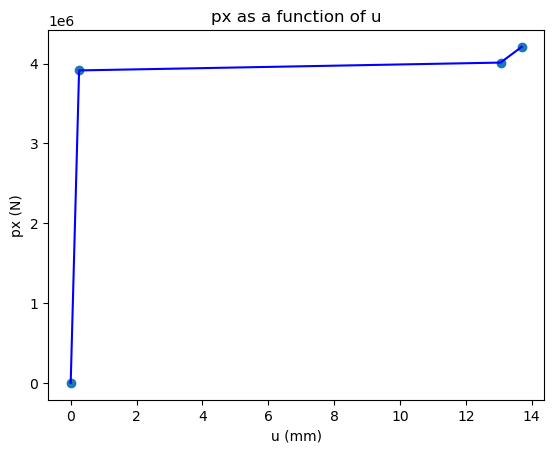

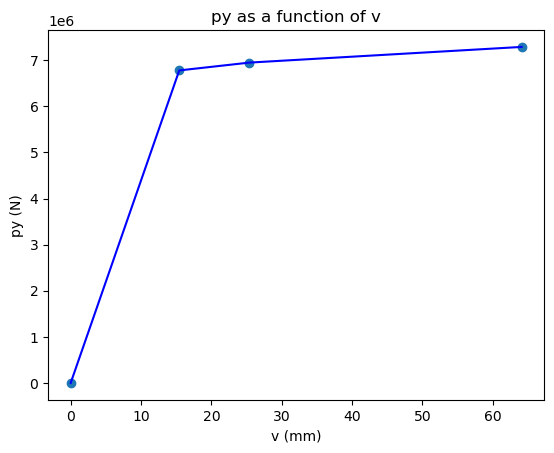

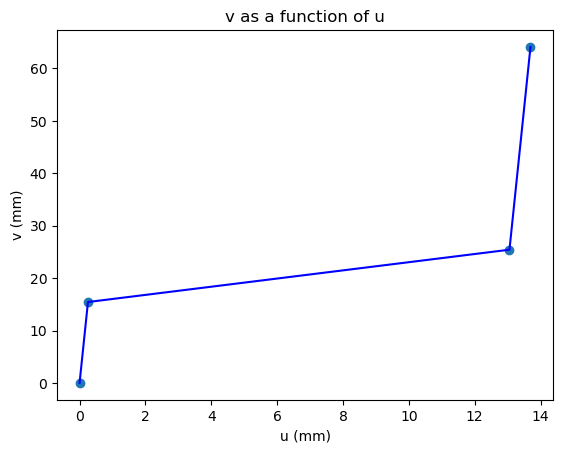

In [5]:
printgraph(u,px,"u","px","mm","N")
printgraph(v,py,"v","py","mm","N")
printgraph(u,v,"u","v","mm","mm")